# Classical Euler methods

### Table of contents
 1. Chapter 2: Classical Methods
    1. [Section 1.1: Explicit Euler](#explicitEuler)
    1. [Section 1.2: Implicit Euler](#implicitEuler)

In [4]:
# Loading/installing packages

# This is the basic package in python with all the numerical functions
try:
    import numpy as np
except ImportError:
    %pip install numpy
    import numpy as np

# This package allows to  plot
try:
    import matplotlib.pyplot as plt 
except ImportError:
    %pip install matplotlib
    import matplotlib.pyplot as plt 

#This package already implemented some functions for Runge Kutta and multistep methods
try:
    from nodepy import rk
except ImportError:
    %pip install nodepy
    from nodepy import rk

# This package has some functions to deal with polynomials
try:
    from scipy import optimize
except ImportError:
    %pip install scipy
    from scipy import optimize

We want to **approximate** the ODE on $I:=[t_0, t_{end}]\subset \mathbb{R}$ for the unknown variable $y:I\to \mathbb{R}^{S}$ with *continuous* function $F:I\times \mathbb{R}^S\to\mathbb{R}^S$

$$
\begin{equation}
\begin{cases}
\frac{dy}{dt} = F(t,y(t)),\\
y(0)=y_0.
\end{cases}
\end{equation}
$$

* Why approximate? Solution may be unknown, or too complicated to be solved analytically.
* How we want to approximate? We want to be **accurate** and we want to preserve the physical properties we have seen before.

## Explicit Euler <a id='explicitEuler'></a>

Consider the time interval $I=[t_0,t_{end}]$ and let us subdivide it into $N$ subintervals, 

$$t_0=t^0<t^1< \dots <t^n < \dots <t^N=t_{end}.$$

We approximate naïvely the integral form

$$ y(t^{n+1})=y(t^n) +\int_{t^n}^{t^{n+1}} F(s,y(s))ds \approx y(t^n) -\underbrace{(t^{n+1}-t^n)}_{\Delta t^n} F(t^n,y(t^n)) $$

leading to the method (forward Euler/explicit Euler), where we use $y^n$ to approximate $y(t^n)$

$$
\begin{cases}
y^0=y_0,\\
y^{n+1}=y^n+\Delta t^n F(t^n,y^n), \qquad n=0,\dots, N-1.
\end{cases}
$$

In [5]:
# Simple implementation of the method
# Input are F, (t^0,...,t^N), y_0
def explicitEuler(func, tspan, y_0):
    '''
    Simple implementation of the explicit Euler method
    Input are 
    func the function F of the ODE which takes as input y and t F(y,t)
    tspan is the vector of all timesteps (t^0,...,t^N)
    y_0 is the initial condition
    '''
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    for n in range(N_time-1):    # n=0,..., N-1
        y[:,n+1]=y[:,n]+ (tspan[n+1]-tspan[n])*func(y[:,n],tspan[n]) ## Code the explicit euler step
    return tspan, y 

Test on 
$$
\begin{equation*}
\begin{cases}
c_1'(t)=c_2(t)-5c_1(t),\\
c_2'(t)=5c_1(t)-c_2(t),
\end{cases}
\end{equation*}
$$
with 
$$
\begin{equation*}
\begin{cases}
 c_1(0)=c_1^0=0.9, \quad  &c_2(0)=c_2^0=0.1,  \\
 t\in [0,3].
 \end{cases}
\end{equation*}
$$


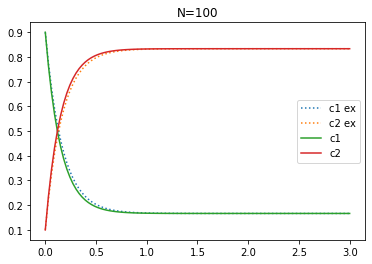

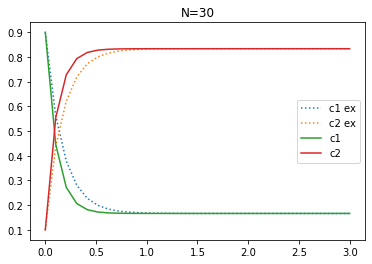

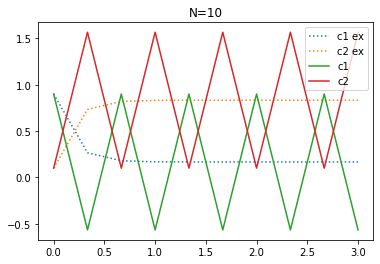

In [6]:
# Define the function F
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]-5*y[0]
    F[1] = -F[0]
    return F

## Now we plot the solution with different number of timesteps
for N in [100,30,10]:
    tspan=np.linspace(0,3,N)
    y0=np.array([0.9,0.1])

    tt,yy=explicitEuler(linSysF,tspan,y0)

    A=np.array([[-5,1],[5,-1]])

    y_exact=np.zeros((len(y0),len(tt)))
    for it, t in enumerate(tt):
        y_exact[:,it]=y0+(1-np.exp(-6*t))/6*np.dot(A,y0)

    plt.figure()
    plt.plot(tt,y_exact[0,:],":", label="c1 ex")
    plt.plot(tt,y_exact[1,:],":", label="c2 ex")

    plt.plot(tt,yy[0,:],label="c1")
    plt.plot(tt,yy[1,:],label="c2")
    plt.title("N=%d"%N)
    plt.legend()

Preliminary, we can observe that
1. The more the points we put in the time discretization the better the solution gets
1. Explicit Euler does not preserve **unconditionally** the positivity of the solution ($N=10$)
1. The total mass is conserved 

$$ c_1^{n+1}+c_2^{n+1}=c_1^{n}+c_2^{n}+ \Delta t\left( -5c_1^{n}+c_2^{n}+5c_1^{n}-c_2^{n} \right) = c_1^{n}+c_2^{n} $$

### Error analysis
The error that we observe 
$$e_n=y(t^n)-y^n$$

is composed of several parts that we can divide and study separately.

#### Consistency error
Given the exact solution $y(t)$, we define the consistency error to be

$$
\varepsilon_n = y(t^{n+1})-y(t^n) - \Delta t F(t^n,y(t^n)) = \int_{t^n}^{t^{n+1}} y'(t) -y'(t^n)\, dt.
$$

Notice that $|\varepsilon_n|\leq \Delta t \omega (y',\Delta t)$, where $\omega$ is the modulus of continuity of a bounded function, i.e.,
$$
\omega(f,\Delta t):= \max_{t,t': |t-t'|\leq \Delta t} |f(t)-f(t')|.
$$

Essentially, this is the error that we obtain by substituting the exact solution inside the method. It is one of the 2 ingredients that leads the error of a method.

Going back to the error, we observe that

$$
e_{n+1}=y(t^{n+1})-y^{n+1}=e_n +\varepsilon_n +\Delta t \big(f(t^n,y(t^n))-f(t^n,y^n)\big)
$$

using the Lipschitz continuity of $f$, we have

$$
|e_{n+1}|\leq |e_n| +|\varepsilon_n| +\Delta t L|y(t^n)-y^n| =(1+L\Delta t)|e_n| +|\varepsilon_n|.
$$

Using the **Discrete Gronwall Lemma** we obtain that

$$
|e_{n}|\leq e^{L|t^n-t^0|}|e_0| + \sum_{i=0}^{n-1} e^{L(t^n-t^{i+1})}|\varepsilon_i|.
$$

This tells us that, except for the initial error (that usually we can bound accurately or know its error), the consistency error leads this sum. So, if we keep $\varepsilon_n$ small enough, the final error will be small enough. 


Using the estimation for $\varepsilon_i$ and suppose $\Delta t^n=\Delta t$, we can collect
$$
\begin{align}
|e_{n}|&\leq e^{L|t^n-t^0|}|e_0| + \Delta t \omega(y',\Delta t) \sum_{i=0}^{n-1} e^{L(t^n-t^{i+1})}\\
&= e^{L|t^n-t^0|}|e_0| +  \omega(y',\Delta t) \sum_{i=0}^{n-1} \int_{t^i}^{t^{i+1}} e^{L(t^n-t^{i+1})} ds\\
&\leq e^{L|t^n-t^0|}|e_0| +  \omega(y',\Delta t) \sum_{i=0}^{n-1} \int_{t^i}^{t^{i+1}} e^{L(t^n-t^{s})} ds\\
&= e^{L|t^n-t^0|}|e_0| +  \omega(y',\Delta t) \int_{t^0}^{t^{n}} e^{L(t^n-t^{s})} ds\\
&= e^{L|t^n-t^0|}|y^0-y(t^0)| + \omega(y',\Delta t) \frac{e^{L(t^n-t^{0})}-1}{L}.
\end{align}
$$

This shows that the solution converges to the exact one as $\Delta t \to 0$, if the initial datum is correct. Indeed, $w(y',\Delta t) = w(f(\cdot,y(\cdot)),\Delta t)\to 0$ as $\Delta t \to 0$ for $f$ Lipschitz continuous in $y$ and $f$ uniformly continuous in $t$. 


If we know more on the regularity of the solution ($y\in \mathcal C^2$), we can say that

$$
|y(t^n)-y^n|\leq e^{L(t^n-t^0)}|y^0-y(t^0)| + \Delta t \int_{t^0}^{t^n} e^{L(t^n-s)} |y''(s)| ds.
$$


#### Local vs Global Error
A small remark must be done in order to understand how the global error generates from the local one.
The local truncation error is the one given for one time step, i.e., using Taylor expansion and supposing $y^0=y(t^0)$,

$$
e_1=|y^1-y(t^1)|=|y^0 +\Delta t F(t^0,y^0) - \left(y(t^0) + \Delta t y'(t^0) + \frac{1}{2} \Delta t^2 y''(t^0)\right) + \mathcal{O}(\Delta t^3)| = \frac{1}{2} \Delta t^2 |y''(t^0)| +  \mathcal{O}(\Delta t^3).
$$

In one step we see an error of $\mathcal O (\Delta t^2)$, when integrating of the whole time interval $[t^0,t^N]$ one obtains an $\mathcal O (\Delta t)$ as we have seen before.

Naïvely one can see it as if in every step we are adding an $\mathcal O (\Delta t^2)$ to the global error

$$
e_N\approx \sum_{i=1}^N |y(t^i)-y^i| \approx N \Delta t^2 \max_{t\in [t^0,t^N]} |y''(t)| = \frac{t^N-t^0}{\Delta t} \Delta t^2\max_{t\in [t^0,t^N]} |y''(t)|= (t^N-t^0) \Delta t\max_{t\in [t^0,t^N]} |y''(t)|
$$

The **order of accuracy** of a method is the largest *integer* $p$, such that the error can be bounded by

$$
|e_N| \leq C \Delta t^p, \qquad \forall \Delta t \in \mathbb R ^+.
$$

This definition is of course meant to be verified in the limit for $\Delta t\to 0$ (in realistic cases we stop at $\approx 10^{-14}$).

The explicit Euler method is of order (at least) 1. (one can check that it is not 2 with numerical tests)


#### Roundoff effects
We should always keep in mind that the error we studied before is not the only one that a computer produces. 
Indeed, at each operation (initial value, evaluation of $F$, sums, products) we introduce a roundoff error due to the machine precision.
One can get similar estimations to what we have seen before, knowing that the error can be controlled.


We ignore this error in this course.

### Stability
Question: going with $\Delta t \to 0$ should produce nice results, but, what can we say about $\Delta t >>0$?
Can we give a qualitatively say when a method could be stable/reliable in particular when *stiff* problems are considered. *Stiff* problems are the ones for which a "*normal*" discretization can not produce decent results.

This rough description can be made more precise and studied only in limited cases. In particular, we restrict to linear problems with constant coefficients.

$$
y'(t)=My(t)
$$

with $M$ constant matrix. We fix the timestep $\Delta t$. The explicit Euler method gives the update

$$
y^{n}=y^{n-1}+\Delta t M y^{n-1} =(I+\Delta t M) y^{n-1} = (I+\Delta t M)^{n} y^0.
$$

Doing a change of basis given by the nonsingular matrix $S$ so that  $\hat{M}=S^{-1} M S$ is in the Jordan canonical form, and defining $\hat{y}^n=S^{-1} y^n$, we have that

$$
\hat y^{n}=\hat y^{n-1}+\Delta t \hat M \hat{y}^{n-1} =(I+\Delta t \hat M) \hat{y}^{n-1} = (I+\Delta t \hat M)^{n} \hat{y}^0.
$$

This means that for each distinct eigenvalue $q \in \mathbb C$ we can study the linear scalar equation 

$$
y'(t)= q  y(t).
$$

The other components that correspond to the same Jordan block will depend on this solution, but will not contribute to its behaviour.

The final question is whether $(1+\Delta t q)^N$ is an *acceptable* approximation of $e^{N\Delta t q }$.

We are interested in bounded behaviors for $N\to \infty$ , this implies that $|1+\Delta t q|\leq 1$, or that $Re(q)\leq 0$. ($q$ could be complex as it is an eigenvalue of $M$).

Rewriting the problem with $z=q\Delta t$, one can see that 

$$
y^n=y^{n-1}+z y^{n-1}=(1+z)y^{n-1}
$$

and the method will be stable if
$|1+z|\leq 1$, which is the region in the complex plane denoted by a circle of radius 1 with center in $(-1,0)$.

The function $R(z):=1+z$ for the explicit Euler is the *stability function*.
For a general method for the Dahlquist's equation

$$
y'(t)=qy(t)
$$

denoting by $z=\Delta t q$, the method can be written as

$$
y^{n+1}=R(z) y^n.
$$


 
1 x + 1


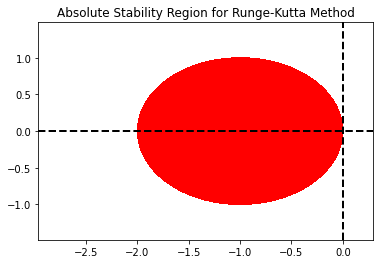

In [7]:
## We will see soon how to write a RK method
## This is the explicit Euler method written into the RK formalism 
## and we plot the stability region using the nodepy module
A=np.array([[0]])
b=np.array([1])
exEuler=rk.ExplicitRungeKuttaMethod(A,b)
p,q=exEuler.stability_function()
print(p)
exEuler.plot_stability_region();

#### How can we ensure the belonging to the stability region?
We want $z=q\Delta t$ to stay in the stability region. On $q$ we do not have control, hence, we can only modify $\Delta t$. 
In particular, denoting $q=p+ir$ with $p,r \in \mathbb R $ and $p\leq 0$, the stability relation we have seen before leads to at least check that the real part verifies the relation

$$
|1+\Delta t p + i \Delta t r|\leq 1 \\
1-\Delta t |p|  \geq 1\\
\Delta t \leq \frac{2}{|p|}
$$

where $|p|$ is for sure bounded by the Lipschitz constant $L$ of the function $F$.

So, it is necessary to check that

$$
\Delta t \leq \frac{2}{L}.
$$

This can be generalized also for nonlinear problems.

#### Imaginary eigenvalues
If the problem we are considering contains only imaginary eigenvalues, then we cannot solve it with explicit Euler method. 
An example is

$$
u''=-u
$$

Consider the exact solution

$$
u=\sin(t)
$$

So, we can put it into a system of first order ODEs with initial conditions

$$
\begin{cases}
u'=v,\\
v'=-u,\\
u(0) = 0,\\
v(0) = 1.
\end{cases}
$$

/tmp/ipykernel_11554/1684803013.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tspan=np.linspace(0,T_end,np.int(T_end/dt)+1)


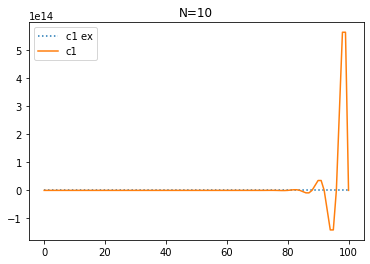

Text(0.5, 1.0, 'Error')

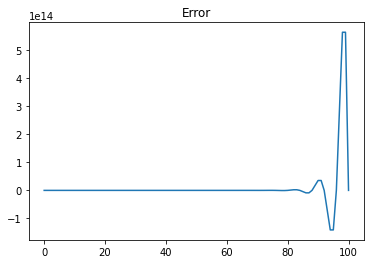

In [8]:
# Define the function F
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]
    F[1] = -y[0]
    return F

## Now we plot the solution with different number of timesteps
dt = 1
T_end = 100

tspan=np.linspace(0,T_end,np.int(T_end/dt)+1)
y0=np.array([0,1])

tt,yy=explicitEuler(linSysF,tspan,y0)

plt.figure()
plt.plot(tt,np.sin(tt),":", label="c1 ex")

plt.plot(tt,yy[0,:],label="c1")
plt.title("N=%d"%N)
plt.legend()
plt.show()

plt.plot(tt,yy[0,:]-np.sin(tt))
plt.title("Error")

## Implicit Euler <a id='implicitEuler'></a>

The implicit Euler method approximates our problem with the following strategy

$$
y^{n+1}=y^n +\Delta t f(t^{n+1},y^{n+1}).
$$

1. It is not always easy to find the solution of such method, for example when $f$ is nonlinear, one may need nonlinear solvers to find the solution (e.g. Newton method, Broyden, and so on)
1. We can compute the error estimate similarly to explicit Euler, obtaining that also implicit Euler is a *first* order method
1. More interesting are the **stability** property of this scheme.

Consider again the Dahlquist's equation

$$y'=qy$$

and the implicit Euler method

$$
\begin{align}
y^{n+1}=y^n+ \Delta t q y^{n+1},\\
(1-\Delta t q) y^{n+1}=y^n,\\
y^{n+1}=\frac{1}{1-\Delta t q} y^n.
\end{align}
$$

So the stability function is $R(z)=\frac{1}{1-z}$ and the stability region $\mathcal S := \lbrace z \in \mathbb C : |R(z)|\leq 1 \rbrace$ contains the whole left complex semiplane. Indeed, if $Re(z)\leq 0,$ then $Re(1-z)\geq 1$ and $|1-z|\geq 1$.
So, $R(z)\leq 1$.

 
1
 
-1 x + 1


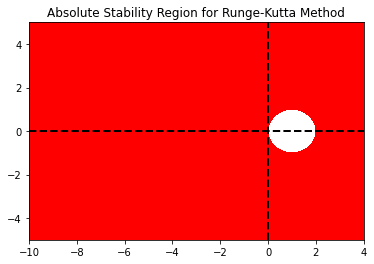

In [9]:
## We will see soon how to write a RK method
## This is the implicit Euler and we plot the stability region
A=np.array([[1]])
b=np.array([1])
imEuler=rk.RungeKuttaMethod(A,b)
p,q=imEuler.stability_function()
print(p) ## Numerator
print(q) ## Denominator
imEuler.plot_stability_region(bounds=[-10,4, -5,5]);

### Nonlinear problems and implicit methods
Differently from the explicit methods, the implicit methods require the solution of possibly nonlinear systems of equations, as the flux $f$ is evaluated in the unknown value $f(u^{n+1})$. This requires the use of nonlinear solvers when $f$ is nonlinear and this can require some extra computational effort.

#### Newton's method for implicit Euler
The simplest way of dealing with nonlinear problems is using Newton's method.
To solve $$y^{n+1} = y^n+ \Delta t f(t^{n+1},y^{n+1})$$
one can proceed iteratively as
$$
u^{(k+1)} =  u^{(k)}- [I-\Delta t Jf(u^{(k)})]^{-1}(u^{(k)}-y^n-\Delta t f(t^{n+1},u^{(k)})),
$$
with $Jf$ being the Jacobian in $y$ of $f(t,y)$.

### Positivity of Implicit Euler (for some classes of problems)
#### Unconditionally positivity for Production--Destruction Systems (PDS)
Consider production-destruction systems (PDS) 

\begin{equation}
\begin{cases}
d_t c_i = P_i(c ) - D_i(c ) , \quad  i=1,\dots,I,\quad & P_i(c) = \sum_{j=1}^I p_{i,j}(c),\\
c(t=0)=c_0,& D_i(c) = \sum_{j=1}^I d_{i,j}(c),
\end{cases}
\end{equation}

where

$$p_{i,j}(c) , d_{i,j} (c) \geq 0, \qquad \forall i,j \in I, \quad \forall c \in \mathbb R^{+,I}.$$

Property 1: Conservation
\begin{align*}
	&\sum_{i=1}^I c_i(0) = \sum_{i=1}^I c_i(t), \quad \forall t\geq 0 \\
	\Longleftrightarrow \quad &p_{i,j}(c)=d_{j,i} (c) , \qquad \forall i,j \in I, \quad \forall c \in \mathbb R^{+,I}. 
\end{align*}

Property 2: Positivity 

\begin{align*}
	&\text{If }P_i,D_i\text{ Lipschitz, and if when } c_i\to 0 \Rightarrow D_i(c)\to 0 \Longrightarrow \\
	&c_i(0) > 0 \,   \forall i \in I \Longrightarrow c_i(t)>0 \,\forall i \in I\; \forall t >0.
\end{align*}

By contradiction, suppose that $c_i(0)>0$ and there exists a $t$ for which $c_i(t)<0$. Then, since the solution is continuous and differentiable, there must have been a time $t^*<t$, where $c_i(t^*)=0$ and $\partial_t c_i(t^*) <0$. This is in contradiction with our hypotheses, indeed,
\begin{align*}
	&\partial_t c_i(t^*) = \underbrace{P_i(c(t^*))}_{\geq 0} - \underbrace{D_i(c(t^*))}_{=0} \geq 0.
\end{align*}



#### Linear PDS
We will see the positivity for a specific case: a production-destruction system with constant coefficient. It can be written as

$$
y'=My
$$

with 

$$
M_{ii}<0,\qquad M_{ij}\geq 0,\, i\neq j, \qquad \sum_{i}M_{ij}=0.
$$

The linear system at the beginning of this chapter falls in this example.

This system is positive if $y_i^0\geq 0$. The implicit Euler is also positive.

$$
(I-\Delta t M)y^{n+1}= y^{n}
$$

##### Theorem
Defining with $A:=I-\Delta t M$, we can prove that $A$ is non singular and that $A^{-1}\geq 0$, i.e., every entry of the matrix is nonnegative.

##### Proof
1. $A$ is strictly diagonally dominant by columns
Indeed, 

$$
0< A_{ii} = 1+\Delta t |M_{ii}| > \Delta t \sum_{j:j\neq i} |M_{ji}| = \sum_{j:j\neq i} |A_{ji}|
$$

Hence, $A$ is nonsingular.

2. The Jacobi method converges and the Jacobi Matrix is positive [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method)


Define the Jacobi matrix $B=D^{-1}(D-A)$, with $D=\text{diag}(A)$.
The diagonal of $B$ is 0 and each element on the off diagonal terms are

$$
B_{ji}=\frac{-A_{ji}}{A_{ii}}, \quad j\neq i. 
$$

So, the spectral radius of $B$ is bounded by

$$
\rho(B)\leq ||B||_{\infty} =\max_{i}\sum_{j\neq i} \frac{|A_{ji}|}{|A_{ii}|} \leq 1.
$$

The iterative Jacobi method is convergent to the solution of $Ay^{n+1}=y^n$.

The method reads

$$
w^{(k+1)}=D^{-1}(y^n- (D-A)w^{(k)})
$$

which is a linear combination of positive matrices and vectors. Hence, the solutions $w^{(k)}$ stay positive if $y^n$ is positive. Knowing that $Dy^{n+1}=(D-A)y^{n+1} +y^n$, the error at each iteration reads

$$
e^{(k+1)}:=w^{(k+1)}-y^{n+1} = D^{-1}(y^n- (D-A)w^{(k)})-D^{-1}(y^n- (D-A)y^{n+1})=D^{-1}(D-A)(w^{(k)}-y^{n+1})= B e^{(k)}.
$$

Knowing that $B$ has norm smaller than 1, we know that the iteration process converges to the solution of the system.

#### Excercise: Prove that implicit Euler is positive for a (nonlinear) PDS


#### Unconditionally TVD/positivity preserving
Another property linked to the positivity of a system is, in finite difference methods for hyperbolic conservation laws, the total variation diminishing (TVD) property.

The clou is that these properties are true independently on the size of $\Delta t$.

For TVD one can read the SSPRK article by Gottlieb, Shu and Tadmor [link](https://www.researchgate.net/publication/2365594_Strong_Stability-Preserving_High-Order_Time_Discretization_Methods).

##### TVD for incremental form problem
The implicit Euler method for incremental problems, i.e.,
$$
U^{n+1}_j=U^{n}_j +\Delta t \left [ C_{j+1/2}(U_{j+1}^{n+1}-U_{j}^{n+1})-D_{j-1/2}(U_{j}^{n+1}-U_{j-1}^{n+1}) \right]
$$

where $C_{j+1/2},D_{j+1/2}\geq 0$ is TVD independently on $\Delta t$.

###### Proof (Harten)
Define 

$$
TV(U^n) = \sum_j |U^n_{j+1}-U^n_j|.
$$

We can compute
\begin{align*}
U^{n+1}_j&=U^{n}_j +\Delta t \left[ C_{j+1/2}(U_{j+1}^{n+1}-U_{j}^{n+1})-D_{j-1/2}(U_{j}^{n+1}-U_{j-1}^{n+1}) \right]\\
\left[ 1+\Delta t (C_{j+1/2}+D_{j+1/2}) \right](U^{n+1}_{j+1}-U_j^{n+1})&=U^{n}_{j+1}-U_j^{n} +\Delta t \left[ C_{j+3/2}(U_{j+2}^{n+1}-U_{j+1}^{n+1})+D_{j-1/2}(U_{j}^{n+1}-U_{j-1}^{n+1}) \right]\\
\left[1+\Delta t (C_{j+1/2}+D_{j+1/2})\right] \lvert U^{n+1}_{j+1}-U_j^{n+1}\rvert &\leq \lvert U^{n}_{j+1}-U_j^{n} \rvert +\Delta t \left[ C_{j+3/2} \lvert U_{j+2}^{n+1}-U_{j+1}^{n+1} \rvert  +D_{j-1/2} \lvert U_{j}^{n+1}-U_{j-1}^{n+1}\rvert \right]\\
TV(U^{n+1}) +\Delta t \sum_j(C_{j+1/2}+D_{j+1/2})|U^{n+1}_{j+1}-U^{n+1}_j| &\leq TV(U^{n}) +\Delta t \sum_j(C_{j+1/2}+D_{j+1/2})|U^{n+1}_{j+1}-U^{n+1}_j| \\
TV(U^{n+1}) &\leq TV(U^n).
\end{align*}

Reminder: Total variation diminishing means for conservation laws, that if the initial solution is positive, it stays positive.

### Implement implicit Euler for linear systems

In [10]:
def implicitEulerLinear(M, tspan, y_0):
    '''
    Simple implementation of the implicit Euler for Linear systems y'=My with M constant matrix
    Input are 
    M the ODE constant matrix
    tspan vector of timesteps (t^0,...,t^N)
    y_0 initial value
    '''
    N_time=len(tspan)  # N+1
    dim=len(y_0)        # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    for n in range(N_time-1):    # n=0,..., N-1
        dt = tspan[n+1]-tspan[n]
        A= np.eye(dim)-dt*M # define the matrix that need to be inverted
        y[:,n+1]=np.linalg.solve(A,y[:,n])
    return tspan, y 

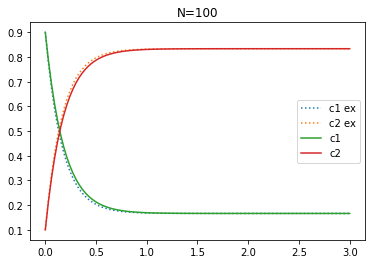

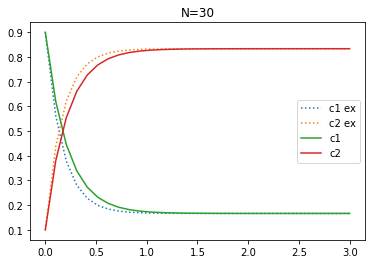

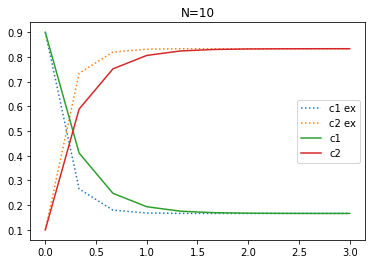

In [23]:
# Test implicit Euler on the linear systems: first the production destruction system with matrix
linSysM=np.array([[-5,1],[5,-1]])

def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = -5*y[0]+y[1]
    F[1] = -F[0]
    return F


for N in [100,30,10]: #testing different number of timesteps
    tspan=np.linspace(0,3,N)  # timesteps between 0 and 3
    y0=np.array([0.9,0.1])    # initial condition

    tt,yy=implicitEulerLinear(linSysM,tspan,y0)  # method implicit euler

    A=np.array([[-5,1],[5,-1]])    # Matrix of the system to plot the exact solution

    y_exact=np.zeros((len(y0),len(tt)))
    for it, t in enumerate(tt): # exact solution at time t
        y_exact[:,it]=y0+(1-np.exp(-6*t))/6*np.dot(A,y0)

    plt.figure() # plotting exact solution
    plt.plot(tt,y_exact[0,:],":", label="c1 ex")
    plt.plot(tt,y_exact[1,:],":", label="c2 ex")
    # plotting implicit euler approximation
    plt.plot(tt,yy[0,:],label="c1")
    plt.plot(tt,yy[1,:],label="c2")
    plt.title("N=%d"%N)
    plt.legend()

#### Let's check the order of accuracy of the implicit and explicit Euler!

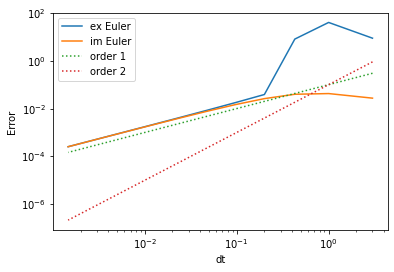

In [19]:
# Convergence error
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]-5*y[0]
    F[1] = -F[0]
    return F

# structures for the exact solution
linSysM=np.array([[-5,1],[5,-1]])

y0=np.array([0.9,0.1])

def exact_sol(t):
    return y0+(1-np.exp(-6*t))/6*np.dot(linSysM,y0)

# integral over time of the difference between the simulation and the exact solution
# to compute the integral error
def error(tt,yy):
    '''
    Compute the average error over the whole time domain, 
    in norm 2 on the components of the system
    '''
    errors=np.zeros(len(tt))
    for it, t in enumerate(tt):
        errors[it]=np.linalg.norm(yy[:,it]-exact_sol(t))
    return np.mean(errors)

# Checking the convergence over different mesh refinements (number of timesteps)
Ns=[2**k for k in range(1,12)]
errorEx=np.zeros(len(Ns))
errorIm=np.zeros(len(Ns))
dts=    np.zeros(len(Ns))


for iN, N in enumerate(Ns): # loop over different Nt
    tspan=np.linspace(0,3,N) # timesteps
    dts[iN]=tspan[1]-tspan[0] # dt
    
    tt,yy=explicitEuler(linSysF,tspan,y0) # explicit Euler simulation
    errorEx[iN]=error(tt,yy)              # explicit Euler error
    tt,yy=implicitEulerLinear(linSysM,tspan,y0) # implicit Euler simulation 
    errorIm[iN]=error(tt,yy)              # implicit Euler error

# Plot of the error wrt to dt in loglog scale (too exponential behaviors dt^p)
plt.figure()
plt.loglog(dts,errorEx,label="ex Euler")
plt.loglog(dts,errorIm, label="im Euler")
plt.loglog(dts,0.1*dts,":", label="order 1")
plt.loglog(dts,0.1*dts**2., ":", label="order 2")
plt.xlabel("dt")
plt.ylabel("Error")
plt.legend()

#### Exercise: implicit Euler on purely imaginary system problem
Use the system introduced before for explicit Euler

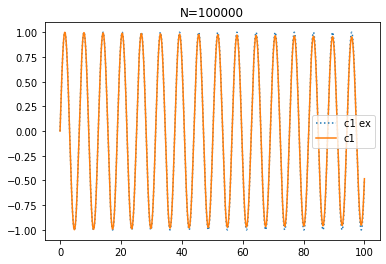

Text(0.5, 1.0, 'Error')

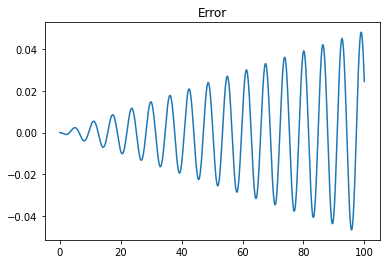

In [29]:
### Test the implicit Euler method with the linear system with purely imaginary eigenvalues

# Define the function F
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]
    F[1] = -y[0]
    return F

linSysM = np.array([[0, 1],[-1, 0]])

## Now we plot the solution with different number of timesteps
dt = 0.001
T_end = 100
N=np.int32(T_end/dt)

tspan=np.linspace(0,T_end,N+1)
y0=np.array([0,1])

tt,yy=implicitEulerLinear(linSysM,tspan,y0)

plt.figure()
plt.plot(tt,np.sin(tt),":", label="c1 ex")

plt.plot(tt,yy[0,:],label="c1")
plt.title("N=%d"%N)
plt.legend()
plt.show()

plt.plot(tt,yy[0,:]-np.sin(tt))
plt.title("Error")

## Extra exercise: code implicit Euler for nonlinear problems
* Use a nonlinear solver to solve $y^{n+1}-\Delta t F(y^{n+1},t^{n+1})=y^n$ (you can use **scipy.optimize.newton**, scipy.optimize.broyden1 or implement your Newton's method)
  * Use lambda function to define the nonlinear function (for nonlinear solvers) 
  * Search the documentation on Google

In [ ]:
def implicitEuler(func, tspan, y_0):
    '''
    Implicit Euler method with a nonlinear solver
    Input:
    func (nonlinear) function fo the ODE
    tspan vector of timesteps (t^0,...,t^N)
    y_0 initial value    
    '''
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    for n in range(N_time-1):    # loop through timesteps n=0,..., N-1
        FILL IN WITH THE OPERATIONS THAT LEAD
        TO THE SOLUTION OF THE NONLINEAR FUNCTION
        y[:,n+1] = ### 
    return tspan, y 

In [ ]:
## Nonlinear 3x3 system production destruction
def nonlinear_system3_flux(u,t=0):
    ff=np.zeros(len(u))
    ff[0]= -u[0]*u[1]/(u[0]+1)
    ff[1]= u[0]*u[1]/(u[0]+1) -0.3*u[1]
    ff[2]= 0.3*u[1]
    return ff

y_0 = np.array([9.98,0.01,0.01])
T_fin = 30

In [ ]:
## Run implicit Euler method and plot the solution
tt=np.linspace(0,T_fin, 100)
tt,yy = implicitEuler(nonlinear_system3_flux, tt, y_0)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("implicit Euler")
plt.plot(tt,yy[0,:])
plt.plot(tt,yy[1,:])
plt.plot(tt,yy[2,:])


tt,yy = explicitEuler(nonlinear_system3_flux, tt, y_0)
plt.subplot(122)
plt.title("explicit Euler")
plt.plot(tt,yy[0,:])
plt.plot(tt,yy[1,:])
plt.plot(tt,yy[2,:])

In [ ]:
## Nonlinear stiff problem: Robertson

def Robertson_flux(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    ff=np.zeros(np.shape(u))
    ff[0] = alpha*u[1]*u[2]-beta*u[0]
    ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
    ff[2] = gamma*u[1]**2
    return ff

NN=10000
tt = np.array([10**k for k in np.linspace(-7,11,NN)])
y_0 = np.array([1.,10**-20,10**-20])

In [ ]:
tt,yy = implicitEuler(Robertson_flux, tt, y_0)
plt.semilogx(tt,yy[0,:])
plt.semilogx(tt,yy[1,:]*10**4)
plt.semilogx(tt,yy[2,:])
plt.ylim([-0.05, 1.05])

In [ ]:
tt,yy = explicitEuler(Robertson_flux, tt, y_0)
plt.semilogx(tt,yy[0,:])
plt.semilogx(tt,yy[1,:]*10**4)
plt.semilogx(tt,yy[2,:])
plt.ylim([-0.05, 1.05])